In [48]:
import numpy as np
import os, json
import pandas as pd
import re
import plotly.express as px
import openai

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from config import MAIN_DIR
from copy import deepcopy
from logging import Logger
from pprint import pprint
from sklearn.manifold import TSNE
from statsmodels.stats.weightstats import ztest
from textdistance import levenshtein
from typing import Dict, Union, List, Literal, Sequence, Optional
from utils import load_vectorindex, count_tokens, get_experiment_logs, filter_by_pages

from llama_index import SimpleDirectoryReader
from llama_index.embeddings import OpenAIEmbedding
from llama_index.embeddings.base import BaseEmbedding
from llama_index.indices.base_retriever import BaseRetriever
from llama_index.schema import Document, NodeWithScore, MetadataMode

In [49]:
DATA_DIR = os.path.join(MAIN_DIR, "data")
ARTIFACT_DIR = os.path.join(MAIN_DIR, "artifacts")
EMB_DIR = os.path.join(DATA_DIR, "emb_store")
DOCUMENT_DIR = os.path.join(MAIN_DIR, "data", "document_sources")
EXCLUDE_DICT = os.path.join(DATA_DIR, "exclude_pages.json")

with open(os.path.join(MAIN_DIR, "auth", "api_keys.json"), "r") as f:
    api_keys = json.load(f)
    
os.environ["OPENAI_API_KEY"] = api_keys["OPENAI_API_KEY"]
openai.api_key = os.environ["OPENAI_API_KEY"]

embed_model = OpenAIEmbedding(model = "text-embedding-ada-002")
save_folder = os.path.join(ARTIFACT_DIR, "retrieval analysis")

In [50]:
def remove_final_sentence(
    text: str,
    return_final_sentence: bool = False
):
    text = text.strip()
    if text.endswith("."):
        text = text[:-1]
    sentence_list = text.split(".")
    previous_text = ".".join(sentence_list[:-1])
    final_sentence = sentence_list[-1]
    return (previous_text, final_sentence) if return_final_sentence else previous_text

def convert_doc_to_dict(doc: Union[Document, NodeWithScore, Dict]) -> Dict:
    """Convert Document objects to json dictionary containing page contents, metadatas and scores

    Args:
        doc (Union[Document, NodeWithScore, Dict]): 

    Returns:
        Dict: Dictionary containing document page content, metadata and score
    """
    if isinstance(doc, NodeWithScore):
        json_doc = {
            "page_content": doc.text,
            "metadata": doc.metadata,
            "score": doc.score
            } 
    elif isinstance(doc, Document):
        json_doc = {
            "page_content": doc.text,
            "metadata": doc.metadata,
            "score": ""
            }
    elif isinstance(doc, Dict):
        json_doc = {
            "page_content": doc["text"],
            "metadata": doc["metadata"],
            "score": "None"
        }
    return json_doc

def query_wrapper(
    template: str, 
    input_text: Union[str, Dict[str, str]]
) -> str:
    """Simple implemnentation of prompt template

    Args:
        template (str): Prompt Template
        input_text (Union[str, Dict[str, str]]): Input content into prompt template

    Returns:
        str: String Prompt
    """
    placeholders = re.findall(pattern = r"{([A-Za-z0-9_-]+)}", string=template)
    if isinstance(input_text, str):
        assert len(placeholders) == 1, "Must Provide a single placeholder when input_text is string."
        placeholder = placeholders[0]
        return template.format(**{placeholder:input_text})
    
    assert len(input_text) == len(placeholders)
    for key in input_text.keys():
        assert key in placeholders, f"{key} not present in template."
    
    return template.format(**input_text)

def calculate_emb_distance(
    emb1: List[float],
    emb2: List[float],
    dist_type: Literal["l2", "ip", "cosine", "neg_exp_l2"] = "l2"
) -> float:
    """Calculate distance between 2 numerical vectors of the same dimension size

    Args:
        emb1 (List[float]): Vector Embedding 1 
        emb2 (List[float]): Vector Embedding 2
        dist_type (Literal[l2, ip, cosine, neg_exp_l2], optional): Type of distance measurement. Defaults to "l2" (Euclidean Distance).

    Returns:
        float: Numerical distance between vector 1 and vector 2
    """
    assert len(emb1) == len(emb2), "Length of embedding vectors must match"
    if dist_type == "l2":
        return np.square(np.linalg.norm(np.array(emb1) - np.array(emb2)))
    elif dist_type == "ip":
        return 1 - np.dot(emb1, emb2)
    elif dist_type == "cosine":
        cosine_similarity = np.dot(emb1, emb2)/(np.norm(emb1)*np.norm(emb2))
        return 1 - cosine_similarity
    elif dist_type == "neg_exp_l2":
        return np.exp(-np.square(np.linalg.norm(np.array(emb1) - np.array(emb2))))
    else:
        raise ValueError("Invalid distance type")
    
def calculate_string_distance(
    str1: str,
    str2: Union[str, Sequence[str]],
    embeddings: BaseEmbedding,
    dist_type: Literal["l2", "ip", "cosine", "neg_exp_l2"] = "l2"
) -> Union[float, List[float]]:
    """Calculate the distance between the input string and a (list of) reference string.

    Args:
        str1 (str): Input string
        str2 (Union[str, Sequence[str]]): Reference string or list of reference stringss
        embeddings (BaseEmbedding): Embedding model for mapping strings to vectors
        dist_type (Literal[l2, ip, cosine, neg_exp_l2], optional): Type of distance measurement. Defaults to "l2" (Euclidean Distance).

    Returns:
        Union[float, List[float]]: Distance or list of distances
    """
    emb1 = embeddings.get_query_embedding(str1)
    if isinstance(str2, str):
        emb2 = embeddings.get_text_embedding(str2)
        return calculate_emb_distance(emb1, emb2, dist_type)
    else:
        emb2_list = embeddings.get_text_embedding_batch(str2)
        return [calculate_emb_distance(emb1, emb2) for emb2 in emb2_list]

In [65]:
testcase_df = pd.read_csv(
        os.path.join(DATA_DIR, "queries", "MSK LLM Fictitious Case Files Full.csv"),
        usecols = ['ACR scenario', 'Guideline', 'Variant', 'Appropriateness Category',
                   'Scan Order', 'Clinical File']
        )
patient_profiles = testcase_df["Clinical File"]
scan_orders = testcase_df["Scan Order"]

question_template = "Patient Profile: {profile}\nScan ordered: {scan_order}"

queries = [
    query_wrapper(question_template, {"profile": remove_final_sentence(patient_profile, True)[0],
                                      "scan_order": remove_final_sentence(patient_profile, True)[1]})
    for patient_profile in patient_profiles
    ]

In [52]:
multimodal_vector_path = os.path.join(DATA_DIR, "multimodal")

with open(os.path.join(multimodal_vector_path, "tables.json"), "r") as f:
    table_list = json.load(f)

with open(os.path.join(multimodal_vector_path, "texts.json"), "r") as f:
    text_list = json.load(f)

In [53]:
table_docs = []
for table in table_list:
    table["metadata"]["mode"] = "tabular"
    doc = Document(
        text=table["text"],
        metadata=table["metadata"],
        excluded_embed_metadata_keys = ['file_name', 'page_label', 'variant', 'mode'],
        excluded_llm_metadata_keys = ['file_name', 'page_label', 'variant']
        )
    table_docs.append(doc)

table_emb_contents = [doc.get_metadata_str(mode=MetadataMode.EMBED) for doc in table_docs]

# with open(os.path.join(save_folder, "tables.json"), "r") as f:
#     table_embs = json.load(f)

table_embs = embed_model.get_text_embedding_batch(table_emb_contents)
with open(os.path.join(save_folder, "tables.json"), "w") as f:
    json.dump(table_embs, f)

for doc, emb in zip(table_docs, table_embs):
    doc.embedding = emb

In [132]:
text_docs = []
for text in text_list:
    text["metadata"]["mode"] = "text"
    doc = Document(
        text=text["text"],
        metadata=text["metadata"],
        excluded_embed_metadata_keys = ['file_name', 'page_label', 'variant', 'mode'],
        excluded_llm_metadata_keys = ['file_name', 'page_label', 'variant']
        )
    text_docs.append(doc)
    
text_emb_contents = [doc.get_content(metadata_mode=MetadataMode.EMBED) for doc in text_docs]

with open(os.path.join(save_folder, "texts.json"), "r") as f:
    text_embs = json.load(f)

text_embs = embed_model.get_text_embedding_batch(text_emb_contents)
with open(os.path.join(save_folder, "texts.json"), "w") as f:
    json.dump(text_embs, f)

for doc, emb in zip(text_docs, text_embs):
    doc.embedding = emb

In [160]:
query_contents = queries
query_embs = embed_model.get_text_embedding_batch(query_contents)
with open(os.path.join(save_folder, "queries.json"), "w") as f:
    json.dump(query_embs, f)

In [134]:
combined_arrays = np.concatenate(
    [
        np.array(table_embs), np.array(text_embs), np.array(query_embs)
    ], axis=0
)

color_mapping = ["red"] * len(table_embs) + ["blue"] * len(text_embs) + ["green"] * len(query_embs)

In [135]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(combined_arrays)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


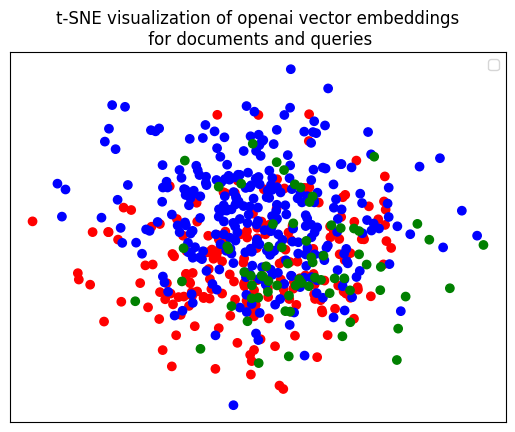

In [136]:
plt.figure()
plt.scatter(combined_arrays[:, 0], combined_arrays[:, 1], color=color_mapping)
plt.title("t-SNE visualization of openai vector embeddings\n for documents and queries")
plt.xticks([], [])
plt.yticks([], [])
plt.legend()

In [79]:
multimodal_vector_path = os.path.join(DATA_DIR, "multimodal-chroma", "descriptions")

tables_index = load_vectorindex(
    db_directory = os.path.join(multimodal_vector_path, "tables"),
    emb_store_type = "chroma", index_name = "tables",
)

texts_index = load_vectorindex(
    db_directory = os.path.join(multimodal_vector_path, "texts"),
    emb_store_type = "chroma", index_name = "texts",
)

2024-04-28 11:07:18,934:INFO: chroma VectorStore successfully loaded from /mnt/c/Users/QUAN/Desktop/lbp_mri/data/multimodal-chroma/descriptions/tables.
2024-04-28 11:07:19,193:INFO: chroma VectorStore successfully loaded from /mnt/c/Users/QUAN/Desktop/lbp_mri/data/multimodal-chroma/descriptions/texts.


In [110]:
K = 5

retrieved_docs = []

for query in queries:

    table_retriever = tables_index.as_retriever(similarity_top_k = K)
    text_retriever = texts_index.as_retriever(similarity_top_k = K)

    retrieved_tables = table_retriever.retrieve(query)
    retrieved_texts = text_retriever.retrieve(query)

    for text_node in retrieved_texts:
        text_node.node.metadata['mode'] = "text"
        
    combined_retrieved_nodes = [(table.score, table) for table in retrieved_tables] + [(text.score, text) for text in retrieved_texts]
    combined_retrieved_nodes.sort(reverse=True)
    sorted_nodes = [node[1] for node in combined_retrieved_nodes]
    
    retrieved_docs.append(sorted_nodes[:K])

In [168]:
color_list = ["green"] * len(query_embs)

retrieved_content_list = []
for retrieved_nodes in retrieved_docs:
    for node in retrieved_nodes:
        node = node.node
        if node.metadata["mode"] == "tabular":
            retrieved_content_list.append(node.get_metadata_str(mode=MetadataMode.EMBED))
            color_list.append("red")
        elif node.metadata["mode"] == "text":
            retrieved_content_list.append(node.get_content(metadata_mode=MetadataMode.EMBED))
            color_list.append("blue")
        else:
            ValueError("Invalid Document Mode")
            
retrieved_content_embs = embed_model.get_text_embedding_batch(retrieved_content_list)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


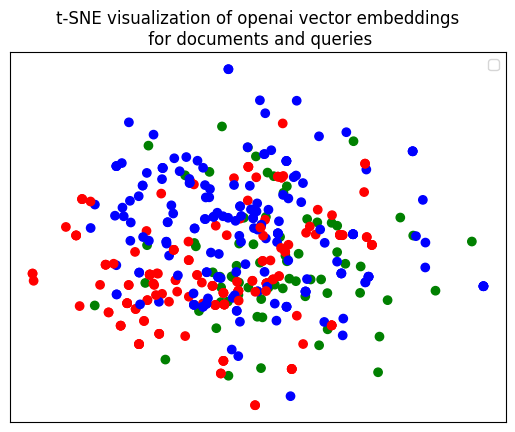

In [176]:
embs_list = deepcopy(query_embs)
embs_list.extend(retrieved_content_embs)

combined_arrays = np.array(embs_list)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(combined_arrays)

plt.figure()
plt.scatter(combined_arrays[:, 0], combined_arrays[:, 1], color=color_list)

# Plot lines
# for query_idx in range(len(queries)):
#     start_idx = len(queries) + query_idx * 5
#     end_idx = start_idx + 5
#     query_node = X_tsne[query_idx, :]
#     for node_idx in range(start_idx, end_idx):
#         retrieved_node = X_tsne[node_idx, :]
#         plt.plot([query_node[0], retrieved_node[0]], [query_node[1], retrieved_node[1]], color = "black", linestyle="-")

plt.title("t-SNE visualization of openai vector embeddings\n for documents and queries")
plt.xticks([], [])
plt.yticks([], [])
plt.legend()